<a href="https://colab.research.google.com/github/gustavohroos/treinamento-h2ia/blob/main/MLP/MLPClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from tqdm import trange
from IPython.core.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

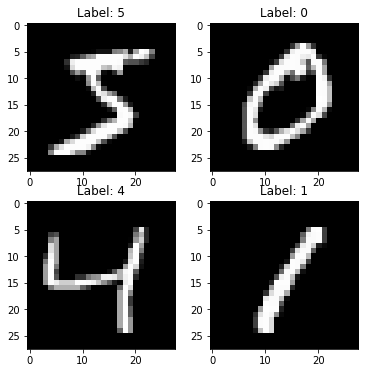

In [45]:
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    X_train = X_train.reshape([X_train.shape[0], -1])
    X_val = X_val.reshape([X_val.shape[0], -1])
    X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test
    
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [46]:
class Layer:
    def forward(self, input):
        return input

    def backward(self, input, grad_output):
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input)

In [47]:
class ReLU(Layer):
    def forward(self, input):
        return np.maximum(input, 0)

    def backward(self, input, grad_output):
        return grad_output * (input > 0)

In [48]:
class Dense(Layer):
    def __init__(self, n_inputs, n_outputs, final_layer=False, learning_rate=0.1):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0,
                                        scale=np.sqrt(2/(n_inputs+n_outputs)),
                                        size=(n_inputs, n_outputs))
        
    def forward(self, input):
        return np.dot(input, self.weights)

    def backward(self, input, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(input.T, grad_output)

        assert grad_weights.shape == self.weights.shape

        self.weights = self.weights - self.learning_rate * grad_weights

        return grad_input


In [49]:
def softmax_crossentropy_with_logits(logits, target):
    logits_for_answers = logits[np.arange(len(logits)), target]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))

    return xentropy

def grad_softmax_crossentropy_with_logits(logits, target):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), target] = 1

    softmax = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)

    return (- ones_for_answers + softmax) / logits.shape[0]

In [50]:
class MLP:

    def __init__(self):
        self.network = []

    def add_layer(self, layer, hidden=True):
        self.network.append(layer)
        if hidden: self.network.append(ReLU())
        
    def forward(self, X):
        activations = []
        input = X

        for layer in self.network:
            activations.append(layer.forward(input))
            input = activations[-1]

        assert len(activations) == len(self.network)

        return activations

    def predict(self, X):
        logits = self.forward(X)[-1]
        return np.argmax(logits, axis=-1)

    def fit(self, X, y):          

        layer_activations = self.forward(X)
        layer_inputs = [X]+layer_activations
        logits = layer_activations[-1]

        self.loss = softmax_crossentropy_with_logits(logits, y)
        loss_grad = grad_softmax_crossentropy_with_logits(logits, y)

        for layer_index in range(len(self.network))[::-1]:
            layer = self.network[layer_index]

            loss_grad = layer.backward(layer_inputs[layer_index], loss_grad)
        
        return self.loss

    def print_layers(self):
        count = 0
        count_layer = 1
        for index, layer in enumerate(self.network):
            if count%2 == 0: 
                print(f'Layer {count_layer} shape: {layer.weights.shape}')
                count_layer += 1
            count +=1

In [51]:
model = MLP()
model.add_layer(Dense(X_train.shape[1], 200))
model.add_layer(Dense(200, 200))
model.add_layer(Dense(200, 100))
model.add_layer(Dense(100, 10), hidden=False)
model.print_layers()

Layer 1 shape: (784, 200)
Layer 2 shape: (200, 200)
Layer 3 shape: (200, 100)
Layer 4 shape: (100, 10)


In [52]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    
    if shuffle: indices = np.random.permutation(len(inputs))
    
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle: excerpt = indices[start_idx:start_idx + batchsize]
        else: excerpt = slice(start_idx, start_idx + batchsize)
        
        yield inputs[excerpt], targets[excerpt]
        
def train_epochs(X_train, y_train, model, X_val, y_val):
    train_log = []
    val_log = []
    print("Untrained network")
    print("Train accuracy:",np.mean(model.predict(X_train)==y_train))
    print("Val accuracy:",np.mean(model.predict(X_val)==y_val))
    for epoch in range(10):
        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
            model.fit(x_batch,y_batch)
        train_log.append(np.mean(model.predict(X_train)==y_train))
        val_log.append(np.mean(model.predict(X_val)==y_val))
        # clear_output()
        print("Epoch",epoch+1)
        print("Train accuracy:",train_log[-1])
        print("Val accuracy:",val_log[-1])
    return train_log, val_log

In [53]:
train_log, val_log = train_epochs(X_train, y_train, model, X_val, y_val)

Untrained network
Train accuracy: 0.13
Val accuracy: 0.1339


100%|██████████| 1562/1562 [00:08<00:00, 175.01it/s]


Epoch 1
Train accuracy: 0.9665
Val accuracy: 0.9622


100%|██████████| 1562/1562 [00:08<00:00, 179.39it/s]


Epoch 2
Train accuracy: 0.9763
Val accuracy: 0.9655


100%|██████████| 1562/1562 [00:08<00:00, 175.51it/s]


Epoch 3
Train accuracy: 0.98452
Val accuracy: 0.9732


100%|██████████| 1562/1562 [00:08<00:00, 177.83it/s]


Epoch 4
Train accuracy: 0.98654
Val accuracy: 0.9722


100%|██████████| 1562/1562 [00:08<00:00, 178.73it/s]


Epoch 5
Train accuracy: 0.98866
Val accuracy: 0.9732


100%|██████████| 1562/1562 [00:08<00:00, 174.81it/s]


Epoch 6
Train accuracy: 0.99266
Val accuracy: 0.9731


100%|██████████| 1562/1562 [00:09<00:00, 162.54it/s]


Epoch 7
Train accuracy: 0.99458
Val accuracy: 0.9766


100%|██████████| 1562/1562 [00:08<00:00, 178.66it/s]


Epoch 8
Train accuracy: 0.9964
Val accuracy: 0.9777


100%|██████████| 1562/1562 [00:08<00:00, 181.09it/s]


Epoch 9
Train accuracy: 0.9973
Val accuracy: 0.98


100%|██████████| 1562/1562 [00:09<00:00, 171.70it/s]


Epoch 10
Train accuracy: 0.9983
Val accuracy: 0.978


Epoch 10
Train accuracy: 0.9983
Val accuracy: 0.978


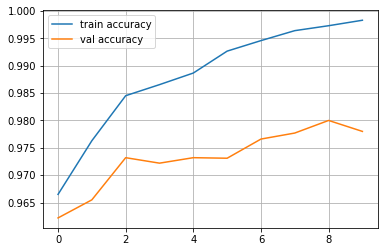

In [54]:
print("Epoch",10)
print("Train accuracy:",train_log[-1])
print("Val accuracy:",val_log[-1])
plt.plot(train_log,label='train accuracy')
plt.plot(val_log,label='val accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [55]:
def plot_predictions(data, target, prediction, n_plots=8,figsize=[15,15]):
  plt.figure(figsize=figsize)
  for i in range(n_plots):
      plt.subplot(n_plots/2, n_plots/2, i+1)
      plt.title(f'Target: {target[i]}   Predicted: {prediction[i]}')
      plt.imshow(data[i].reshape([28,28]),cmap='gray');

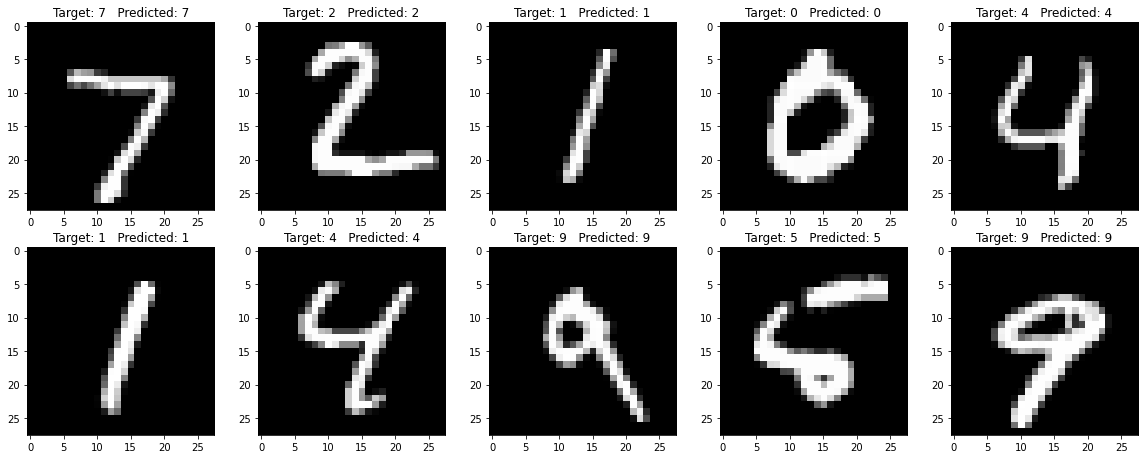

In [56]:
prediction = model.predict(X_test)
plot_predictions(X_test, y_test, prediction, n_plots=10, figsize=[20,20])

In [57]:
print(f'Final accuracy w/ X_test: {np.mean(prediction==y_test)}')

Final accuracy w/ X_test: 0.9805


##References
https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9<br/>
https://www.youtube.com/watch?v=0oWnheK-gGk<br/>
https://www.kaggle.com/code/vitorgamalemos/multilayer-perceptron-from-scratch/notebook